<a href="https://colab.research.google.com/github/vikash-collab/Covid-19-Cases-Tracking/blob/main/smart_pathway_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Load Libraries and Dataset**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

# Load dataset
file_path = 'smart_mobility_dataset.csv'
try:
    df = pd.read_csv(file_path)
    print(f"✅ Dataset '{file_path}' loaded successfully!")
    df.head()
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure it is uploaded to your Colab session's file directory.")

Error: The file 'smart_mobility_dataset.csv' was not found.
Please make sure it is uploaded to your Colab session's file directory.


### **Perform Exploratory Data Analysis**

In [15]:
print("--- Dataset Information ---")
df.info()


print("\n--- Statistical Summary ---")
print(df.describe())

# Visualize the distribution of traffic conditions
print("\n--- Visualizing Traffic Condition Distribution ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 5))
sns.countplot(
    x='Traffic_Condition',
    data=df,
    order=['Low', 'Medium', 'High'],
    palette='viridis'
)
plt.title('Distribution of Traffic Conditions', fontsize=16)
plt.xlabel('Traffic Condition', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

--- Dataset Information ---


NameError: name 'df' is not defined

### **Generate Interactive Mobility Heatmap**

In [7]:

# Create a base map centered around the data's average coordinates
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
traffic_map = folium.Map(location=map_center, zoom_start=12)

# Prepare data for the HeatMap layer (lat, lon, weight)
heat_data = df[['Latitude', 'Longitude', 'Vehicle_Count']].values.tolist()

# Add the HeatMap layer to the map
HeatMap(heat_data, radius=15).add_to(traffic_map)

traffic_map

NameError: name 'df' is not defined

### **Identify Congestion Hotspots with K-Means**

In [ ]:

high_congestion_df = df[df['Traffic_Condition'] == 'High'].copy()

# Check if there are enough high congestion points to cluster
if len(high_congestion_df) >= 5:
    print(f"Found {len(high_congestion_df)} high-congestion events. Proceeding with clustering.")

    # Prepare the geographical data for clustering
    coords = high_congestion_df[['Latitude', 'Longitude']]

    # Apply the K-Means algorithm to find 5 hotspots
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
    high_congestion_df['cluster'] = kmeans.fit_predict(coords)

    hotspots = kmeans.cluster_centers_

    # Visualize the hotspots on a new map
    hotspot_map = folium.Map(location=map_center, zoom_start=12)

    # Add the cluster centers (hotspots) to the map as markers
    for i, hotspot in enumerate(hotspots):
        folium.Marker(
            location=[hotspot[0], hotspot[1]],
            popup=f"Congestion Hotspot #{i+1}",
            tooltip=f"Identified Center of High Congestion",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(hotspot_map)

    print("\nDisplaying map with identified congestion hotspots from your data.")
    display(hotspot_map)

else:
    print(f"Only found {len(high_congestion_df)} high-congestion data points. This is not enough for clustering. Consider reducing 'n_clusters' or checking your data.")

Found 3166 high-congestion events. Proceeding with clustering.

Displaying map with identified congestion hotspots from your data.


### **Analyze Congestion vs. Time of Day**

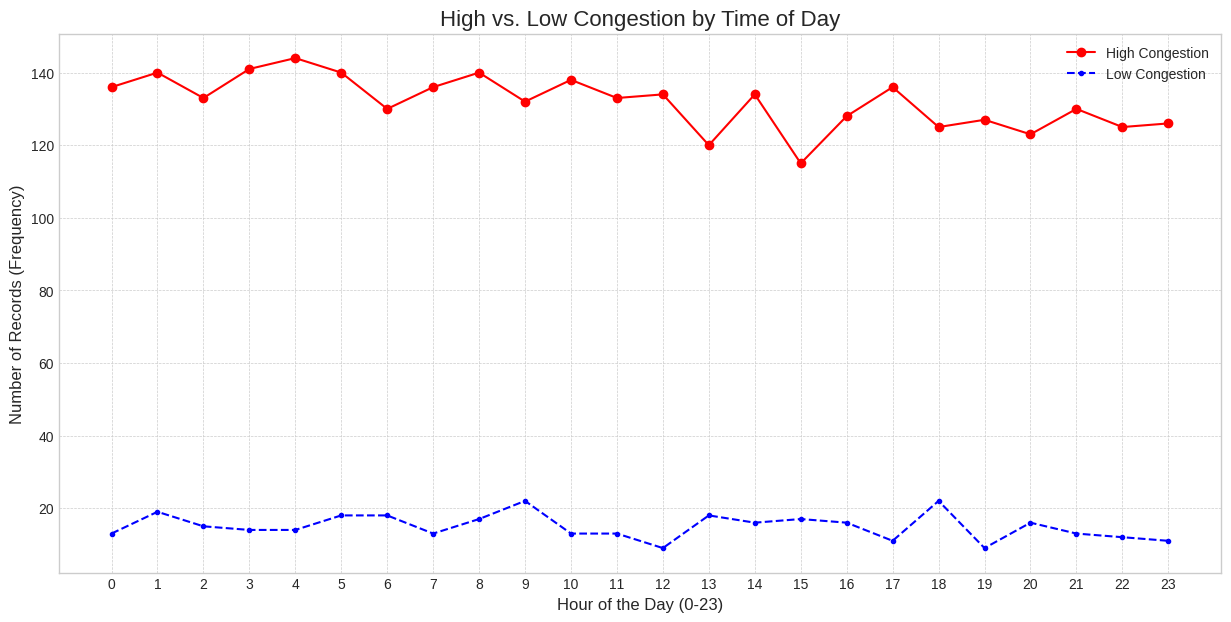

In [ ]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df['Hour'] = df['Timestamp'].dt.hour

# Calculate the counts of each traffic condition per hour
hourly_counts = df.groupby('Hour')['Traffic_Condition'].value_counts().unstack().fillna(0)

# Create the line plot for High vs. Low congestion
plt.figure(figsize=(15, 7))
plt.plot(hourly_counts.index, hourly_counts.get('High', 0), color='red', marker='o', linestyle='-', label='High Congestion')
plt.plot(hourly_counts.index, hourly_counts.get('Low', 0), color='blue', marker='.', linestyle='--', label='Low Congestion')

plt.title('High vs. Low Congestion by Time of Day', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=12)
plt.ylabel('Number of Records (Frequency)', fontsize=12)
plt.xticks(ticks=range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### **Pathway Efficiency Scoring Model**

In [ ]:
# Create a mapping for Traffic_Condition
traffic_map = {'Low': 3, 'Medium': 2, 'High': 1}
df['Traffic_Value'] = df['Traffic_Condition'].map(traffic_map)

# Normalize Traffic Speed for fair comparison
min_speed = df['Traffic_Speed_kmh'].min()
max_speed = df['Traffic_Speed_kmh'].max()
df['Normalized_Speed'] = (df['Traffic_Speed_kmh'] - min_speed) / (max_speed - min_speed)

# Calculate the final Efficiency Score
df['Efficiency_Score'] = df['Traffic_Value'] * df['Normalized_Speed']

print("--- Pathway Efficiency Score Calculation ---")
print(df[['Traffic_Condition', 'Traffic_Value', 'Traffic_Speed_kmh', 'Normalized_Speed', 'Efficiency_Score']].head())
print(f"\nAverage Efficiency Score across all data points: {df['Efficiency_Score'].mean():.3f}")

--- Pathway Efficiency Score Calculation ---
  Traffic_Condition  Traffic_Value  Traffic_Speed_kmh  Normalized_Speed  \
0              High              1          49.893435          0.598584   
1              High              1          22.383965          0.231765   
2              High              1          46.889699          0.558531   
3              High              1           5.730536          0.009704   
4               Low              3          61.348034          0.751322   

   Efficiency_Score  
0          0.598584  
1          0.231765  
2          0.558531  
3          0.009704  
4          2.253967  

Average Efficiency Score across all data points: 0.765


### **Smart Pathway Re-design based on Hotspots**

In [ ]:
def get_hotspot_efficiency(hotspot_coords, df, radius=0.01):
    """Calculates the average efficiency score in the vicinity of a hotspot."""
    lat, lon = hotspot_coords

    # Filter data points within a small geographical radius of the hotspot
    nearby_data = df[
        (df['Latitude'] >= lat - radius) & (df['Latitude'] <= lat + radius) &
        (df['Longitude'] >= lon - radius) & (df['Longitude'] <= lon + radius)
    ]

    if len(nearby_data) > 0:
        return nearby_data['Efficiency_Score'].mean(), len(nearby_data)
    else:
        return 0, 0

print("\n--- Hotspot Efficiency Analysis and Pathway Proposal ---")
pathway_proposals = []


map_center = [df['Latitude'].mean(), df['Longitude'].mean()]

for i, hotspot in enumerate(hotspots):
    avg_efficiency, count = get_hotspot_efficiency(hotspot, df)

    if avg_efficiency > 0.6:
        proposal = "Optimal flow. Minor improvements only."
        action_color = 'green'
    elif avg_efficiency > 0.4:
        proposal = "Moderate congestion. Suggest real-time traffic light optimization."
        action_color = 'orange'
    else:
        proposal = "**Critical Congestion.** Propose immediate pathway re-design (e.g., add by-pass or dedicated flow lane)."
        action_color = 'red'

    pathway_proposals.append({
        'Hotspot_ID': i + 1,
        'Latitude': hotspot[0],
        'Longitude': hotspot[1],
        'Avg_Efficiency_Score': f"{avg_efficiency:.3f}",
        'Data_Points_Nearby': count,
        'Proposal': proposal,
        'Color': action_color
    })

# Display the final proposals as a DataFrame
proposal_df = pd.DataFrame(pathway_proposals)
print(proposal_df.to_markdown(index=False))

# Visualize the proposals on a map
proposal_map = folium.Map(location=map_center, zoom_start=12)

# Add the cluster centers with colored markers based on their proposal
for row in proposal_df.itertuples():
    folium.Marker(
        location=[row.Latitude, row.Longitude],
        popup=f"Hotspot #{row.Hotspot_ID}<br>Avg. Efficiency: {row.Avg_Efficiency_Score}<br>Proposal: {row.Proposal}",
        tooltip=f"Hotspot {row.Hotspot_ID}",
        icon=folium.Icon(color=row.Color, icon='cogs' if row.Color == 'red' else 'leaf')
    ).add_to(proposal_map)

print("\nDisplaying map with proposed infrastructure actions.")
display(proposal_map)


--- Hotspot Efficiency Analysis and Pathway Proposal ---
|   Hotspot_ID |   Latitude |   Longitude |   Avg_Efficiency_Score |   Data_Points_Nearby | Proposal                                                           | Color   |
|-------------:|-----------:|------------:|-----------------------:|---------------------:|:-------------------------------------------------------------------|:--------|
|            1 |    40.744  |    -73.8485 |                  0.639 |                   21 | Optimal flow. Minor improvements only.                             | green   |
|            2 |    40.8343 |    -73.7676 |                  0.584 |                   20 | Moderate congestion. Suggest real-time traffic light optimization. | orange  |
|            3 |    40.8336 |    -73.934  |                  0.824 |                   26 | Optimal flow. Minor improvements only.                             | green   |
|            4 |    40.6661 |    -73.9315 |                  0.834 |                   